<a href="https://colab.research.google.com/github/mnocerino23/NBA-Player-Classifier/blob/main/NeuralNetwork_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In this notebook we experiment with Neural Networks to decide who does and does not deserve a max contract (binary classifier). In this revised jupyter notebook, we try to remove outliers and see how this effects the model

In [130]:
import pandas as pd
import sklearn
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
complete = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/NBA/complete22-23.csv')

In [132]:
complete.head(4)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST_TOV,OWS_div_USG,TS_times_USG,bigmanD,foul_rate,three_rate,PTs_per_36,PF_per_dplay,FG_TOV,two_way
0,Precious Achiuwa,C,23,TOR,55,12,20.7,3.6,7.3,0.485,...,0.818182,0.041237,10.7476,0.251208,0.091787,21.505376,16.000000,1.727273,3.727273,38.690909
1,Steven Adams,C,29,MEM,42,42,27.0,3.7,6.3,0.597,...,1.210526,0.089041,8.2344,0.314815,0.085185,0.000000,11.466667,1.150000,1.947368,87.500000
2,Bam Adebayo,C,25,MIA,75,75,34.6,8.0,14.9,0.540,...,1.280000,0.142857,14.9184,0.251445,0.080925,1.324503,21.225434,1.400000,3.200000,101.840000
3,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,0.427,...,1.571429,0.056962,8.8638,0.092683,0.082927,37.500000,13.873171,2.833333,6.000000,6.440678


In [133]:
#note that some players have multiple positions
complete['Pos'].unique()

array(['C', 'SG', 'PF', 'PG', 'SF', 'PF-SF', 'SF-SG', 'SG-PG'],
      dtype=object)

In [134]:
#we want to make sure each player has only one position to limit the amount of categories for Pos.
#although we don't need to one hot encode for our tree based model, limiting all 
#entries to just one position is still important

for index, rows in complete.iterrows():
  #if the position has length greater than two (meaning it isn't C, PG, SG, SF, or PF), we shorten it to the first position
  if len(complete.at[index, 'Pos']) > 2:
    complete.at[index, 'Pos'] = complete.at[index, 'Pos'][:2]

# Players with salaries over 25 million will be considered max level players while those under with be considered "Not max"

In [135]:
#use a lambda function to assign classes
complete['Class'] = complete['Salary'].apply(lambda x: 1 if x > 25 else 0)

In [136]:
#the count of each class in the dataset before splitting
complete['Class'].value_counts()

0    398
1     52
Name: Class, dtype: int64

Before splitting into train-test, we need to drop outliers that have been identified such as Kyle Lowry, John Wall, Gordon Hayward, and Ben Simmons. These are players who have all severly fallen off after receiving max contracts and should not appear in the training set.

In [137]:
#need to remove john wall, Gordon Hayward, Ben Simmons from the training set

In [138]:
need_to_remove = ['John Wall', 'Gordon Hayward', 'Ben Simmons']
for player in need_to_remove:
  complete = complete.drop(complete[complete['Player'] == player].index)

In [139]:
from sklearn.model_selection import train_test_split, cross_val_score

In [140]:
#split into input features and target variable class
X = complete.drop(columns = ['Salary', 'Class'], axis = 1)
y = complete['Class']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5, test_size=0.2, shuffle = True)

In [142]:
#drop the names column before proceeding
names_train = list(X_train['Player'])
X_train.drop(columns = ['Player', 'Tm', 'Pos'], axis = 1, inplace = True)
names_test = list(X_test['Player'])
X_test.drop(columns = ['Player','Tm', 'Pos'], axis = 1, inplace = True)

In [143]:
print('Train:')
print('train_features dimensions: ', X_train.shape)
print('train_target dimensions: ', y_train.shape, '\n')


print('Test:')
print('test_features dimensions: ', X_test.shape)
print('test_target dimensions: ', y_test.shape)

Train:
train_features dimensions:  (357, 59)
train_target dimensions:  (357,) 

Test:
test_features dimensions:  (90, 59)
test_target dimensions:  (90,)


In [154]:
#use keras within tensorflow since I have used this in the past
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(5)

nn = tf.keras.models.Sequential()
nn.add(tf.keras.Input(shape=(59,)))
nn.add(tf.keras.layers.Dense(15, activation='relu'))
nn.add(tf.keras.layers.Dense(30, activation='relu'))
nn.add(tf.keras.layers.Dense(30, activation='relu'))
nn.add(tf.keras.layers.Dense(15, activation='relu'))
nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

nn.compile(
   loss=tf.keras.losses.BinaryCrossentropy(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics="accuracy")

history = nn.fit(X_train, y_train, epochs=10,validation_data=(X_test,y_test))

Epoch 1/10
12/12 [==============================] - 2s 25ms/step - loss: 0.9364 - accuracy: 0.8739 - val_loss: 0.5584 - val_accuracy: 0.7889
Epoch 2/10
12/12 [==============================] - 0s 5ms/step - loss: 0.4272 - accuracy: 0.8880 - val_loss: 0.2973 - val_accuracy: 0.9111
Epoch 3/10
12/12 [==============================] - 0s 6ms/step - loss: 0.2375 - accuracy: 0.9132 - val_loss: 0.2077 - val_accuracy: 0.9222
Epoch 4/10
12/12 [==============================] - 0s 5ms/step - loss: 0.1981 - accuracy: 0.9188 - val_loss: 0.1743 - val_accuracy: 0.9222
Epoch 5/10
12/12 [==============================] - 0s 5ms/step - loss: 0.1775 - accuracy: 0.9300 - val_loss: 0.1503 - val_accuracy: 0.9333
Epoch 6/10
12/12 [==============================] - 0s 7ms/step - loss: 0.1692 - accuracy: 0.9328 - val_loss: 0.1480 - val_accuracy: 0.9333
Epoch 7/10
12/12 [==============================] - 0s 5ms/step - loss: 0.1617 - accuracy: 0.9384 - val_loss: 0.1388 - val_accuracy: 0.9333
Epoch 8/10
12/12 [=

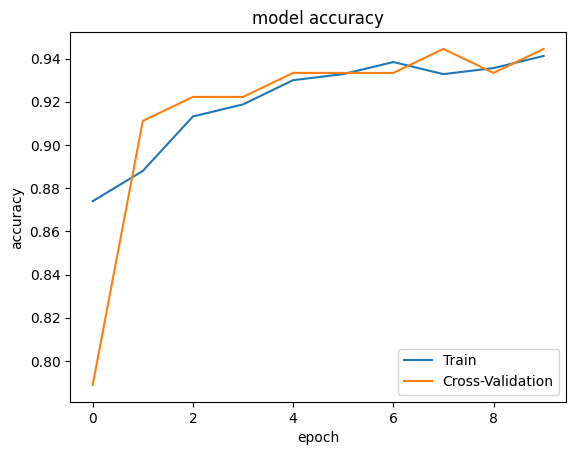

In [155]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='lower right')
plt.show()

In [156]:
from sklearn.metrics import accuracy_score
y_hat_train = nn.predict(X_train)
y_hat_test = nn.predict(X_test)

predicted_classes_train = tf.where(y_hat_train > 0.5, 1, 0)
predicted_classes_test = tf.where(y_hat_test > 0.5, 1, 0)

train_accuracy = accuracy_score(y_train, predicted_classes_train)
test_accuracy = accuracy_score(y_test, predicted_classes_test)

#training_acc.append(train_accuracy)
#testing_acc.append(test_accuracy)

3/3 [==============================] - 0s 3ms/step


In [157]:
print('Train Accuracy: ', train_accuracy)
print('Test Accuracy: ', test_accuracy)

Train Accuracy:  0.9355742296918768
Test Accuracy:  0.9444444444444444
